In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_telco_data
from prepare import prep_telco_data
from prepare import prep_telco_data_prediction

# PLAN

#### Summary
The Codeup Data Science Team wants to understand why Telco customers are churning.

The have suggested the following questions:
   1. Are there clear groupings where a customer is more likely to churn? What if you consider contract type? Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers? 2-year customers? Do you have any thoughts on what could be going on? (Be sure to state these thoughts not as facts but as untested hypotheses. Unless you test them!). Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).
   2. Are there features that indicate a higher propensity to churn? like type of Internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
   3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
   4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

#### Goals
The goals of the project are to answer the questions and deliver the following:
   1. a Jupyter Notebook Report showing process and analysis with goal of finding drivers for customer churn.
   2. a README.md file containing project description with goals, a data dictionary, project planning (lay out your process through the data science pipeline), instructions or an explanation of how someone else can recreate your project and findings (What would someone need to be able to recreate your project on their own?), and key findings and takeaways from your project.
   3. a CSV file with customer_id, probability of churn, and prediction of churn. (1=churn, 0=not_churn)
   4. individual modules, .py files, that hold your functions to acquire and prepare your data.
   

Clearly state your starting hypotheses (and add the testing of these to your task list).

## Data Dictionary

# ACQUIRE

In [2]:
# Observe the original data before cleaning
telco_original = get_telco_data(cached=True)
telco_original.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,...,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,...,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes


In [3]:
telco_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

# PREPARE

The functions from `prepare.py` will need to accomplish the following:

1. There are no nulls in the data set, but there are blank entries in the dataset. Customers with tenure = 0 have a blank entered for their total_charges. These customers haven't had a chance to pay a bill yet, and they also are not capable of churning. Their churn label, though technically present, is meaningless. They will be dropped from the dataframe.

2. Most of these fields are object datatypes and/or contain data that will need to be separated out and/or encoded. These are described in the "Fields to Adjust" section below. 

3. Several new features will need to be created. They are described in the "Features to Create" section below. 

4. total_charges is stored as an object, but the values should be stored as float values. 

### Fields to Adjust
There are a number of fields that will need to be encoded as boolean values as most of the fields in the original dataset are object data type. 

1. **customer_id** - although this field is essentially a duplicate index, one of the deliverables is a CSV file with customer_id, probability of churn, and prediction of churn. (1=churn, 0=not_churn). I will keep this field, but it will not be included as a feature in any of the models. 

In [4]:
telco_original.customer_id.unique()

array(['0002-ORFBO', '0003-MKNFE', '0004-TLHLJ', ..., '9992-UJOEL',
       '9993-LHIEB', '9995-HOTOH'], dtype=object)

2. **gender** - this field needs to be encoded. "Female" will equal 1 and "Male" will equal 0. 

In [5]:
telco_original.gender.unique()

array(['Female', 'Male'], dtype=object)

3. **partner** - this field needs to be encoded. "Yes" will equal 1 and "No" will equal 0.

In [6]:
telco_original.partner.unique()

array(['Yes', 'No'], dtype=object)

4. **dependents** - this field needs to be encoded. "Yes" will equal 1 and "No" will equal 0.

In [7]:
telco_original.dependents.unique()

array(['Yes', 'No'], dtype=object)

5. **phone_service** - this field needs to be encoded. "Yes" will equal 1 and "No" will equal 0.

In [8]:
telco_original.phone_service.unique()

array(['Yes', 'No'], dtype=object)

6. **multiple_lines** - this field currently has Yes, No, and No Phone Service. There is a slight distinction between "No" and "No Phone Service", but these can be combined into a single encoded value for "No", as the phone_service field already captures if the customer has "No Phone Service". This field will be encoded into "Yes" = 1 and "No/No Phone Service" = 0.

In [9]:
telco_original.multiple_lines.unique()

array(['No', 'Yes', 'No phone service'], dtype=object)

7. **internet_service_type_id** - currently 1 = "DSL", 2 = "Fiber Optic", and 3 = "None". This will be encoded by new dummy variables for "DSL" and "Fiber Optic" with numeric boolean values. There is no need to encode for "None", as this will be captured when both "DSL" and "Fiber Optic" are 0.

In [10]:
telco_original.internet_service_type_id.unique()

array([1, 2, 3])

8.-13. **online_security**, **online_backup**, **device_protection**, **tech_support**, **streaming_tv**, **streaming_movies** - These will be encoded with boolean values. "Yes" = 1, "No/No internet service" = 0. Although there is a slight distinction between "No" and "No internet service", the latter will be captured when "DSL" and "Fiber Optic" are both 0. 

In [11]:
print(telco_original.online_security.unique())
print(telco_original.online_backup.unique())
print(telco_original.device_protection.unique())
print(telco_original.tech_support.unique())
print(telco_original.streaming_tv.unique())
print(telco_original.streaming_movies.unique())

['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']


14. **contract_type_id** - This currently codes for three options:
    - Month-to-month : 1
    - One year : 2
    - Two year : 3

Although contract type is roughly ordinal, these numbers are not proportional enough to keep in the same field. This will be split via dummy variables across multiple fields. One year and Two year will be directly encoded for, as month-to-month will be captured when both One year and Two year equal 0. 

In [12]:
telco_original.contract_type_id.unique()

array([2, 1, 3])

15. **paperless_billing** - this field needs to be encoded. "Yes" will equal 1 and "No" will equal 0.

In [13]:
telco_original.paperless_billing.unique()

array(['Yes', 'No'], dtype=object)

16. **payment_type_id** - This currently codes for four options:
    - Electronic Check : 1
    - Mailed Check : 2
    - Bank Transfer (automatic) : 3
    - Credit Card (automatic) : 4
    
This field will be be split up by dummy variables, each one encoded with boolean numeric values. 

In [14]:
telco_original.payment_type_id.unique()

array([2, 1, 4, 3])

17. **churn** - This will need to be encoded with boolean numeric values. 

In [15]:
telco_original.churn.unique()

array(['No', 'Yes'], dtype=object)

### Features to Create

1. "**yearly_tenure**" that represents tenure in years. As monthly tenure is always rounded down, yearly tenure will similarly be rounded down. 
2. "**number_phone_lines**" representing the information from phone_service and multiple_lines where 0 represents no phone service, 1 represents single phone line, 2 represents multiple lines.
3. "**number_relationships**" representing the information from dependents and partner where 0 represents no dependents or partner, 1 represents either a dependent or partner, and 2 represents both a dependent and partner.
4. "**number_streaming_services**" representing the information from streaming_tv and streaming_movie where 0 represents having neither, 1 represents either having streaming_tv or streaming_movie, and 2 represents having both. 
5. "**number_online_services**" representing the information from online_security and online_backup where 0 represents having neither, 1 represents either having online_security or online_backup, and 2 represents having both. 

#### Applying our prepare.py functions to the original dataset

In [16]:
train, test, validate = prep_telco_data(telco_original)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 4216 to 3374
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                4500 non-null   object 
 1   gender                     4500 non-null   object 
 2   senior_citizen             4500 non-null   int64  
 3   partner                    4500 non-null   object 
 4   dependents                 4500 non-null   object 
 5   tenure                     4500 non-null   int64  
 6   phone_service              4500 non-null   object 
 7   multiple_lines             4500 non-null   object 
 8   internet_service_type_id   4500 non-null   int64  
 9   online_security            4500 non-null   object 
 10  online_backup              4500 non-null   object 
 11  device_protection          4500 non-null   object 
 12  tech_support               4500 non-null   object 
 13  streaming_tv               4500 non-null   ob

In [18]:
print(train.shape, validate.shape, test.shape)

(4500, 49) (1407, 49) (1125, 49)


# EXPLORE

In [19]:
# Looking at churn rates across the entire train dataset

In [20]:
train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

Text(0.5, 0, 'Churned')

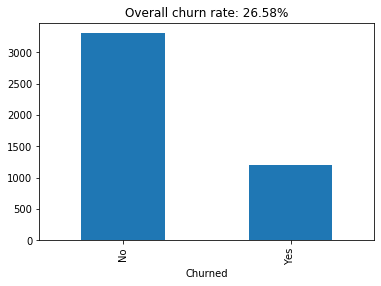

In [21]:
train.churn.value_counts().sort_index().plot.bar()
churn_rate = train.churn_encoded.mean()
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churned')

## Churn Rates by Feature

Churn rates will be visualized for features in the dataset. Visualizations that show the highest difference in churn rate will be tested with the appropriate statistical analysis to confirm significance. 

Note: Combined interactions that would be revealed with complex pivot tables and crosstabs will not be evaluated at this time. If I had more time, I would also consider multidimensional interactions. 

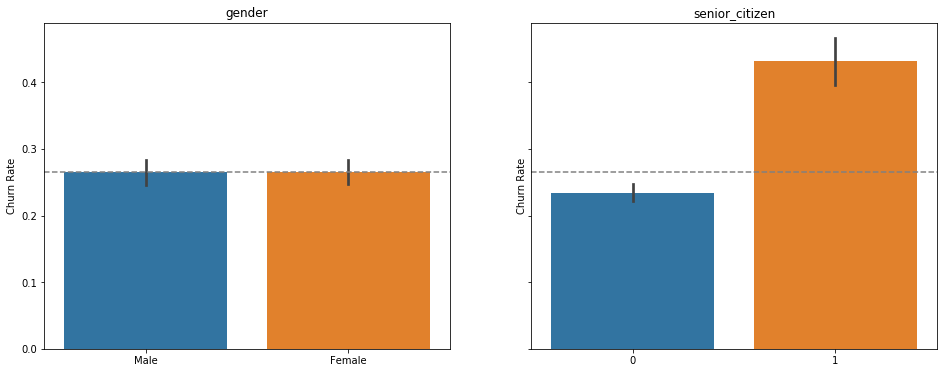

In [22]:
features = ['gender', 'senior_citizen']

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Takeaways:
  - **Gender** - It does not appear that gender is related to churn. Both genders have effectively equal churn rates.
  - **Senior Citizens** - Senior citizens have a higher churn rate than non-seniors.

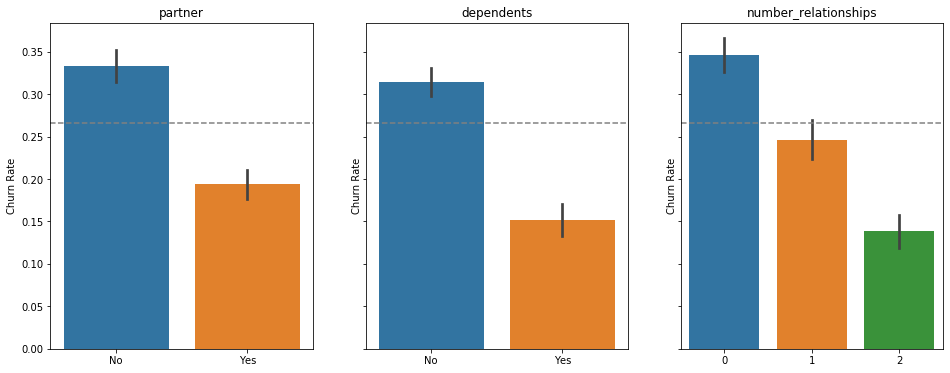

In [23]:
features = ['partner', 'dependents', 'number_relationships']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Takeaways
- **Partners** - Customers with partners have a lower churn rate than customers without partners. 
- **Dependents** - Customers with dependents have lower rates of churn.
- **Number relationships** - Customers with both partners and dependents have lower rates of churn than customers with only partners or dependents. 

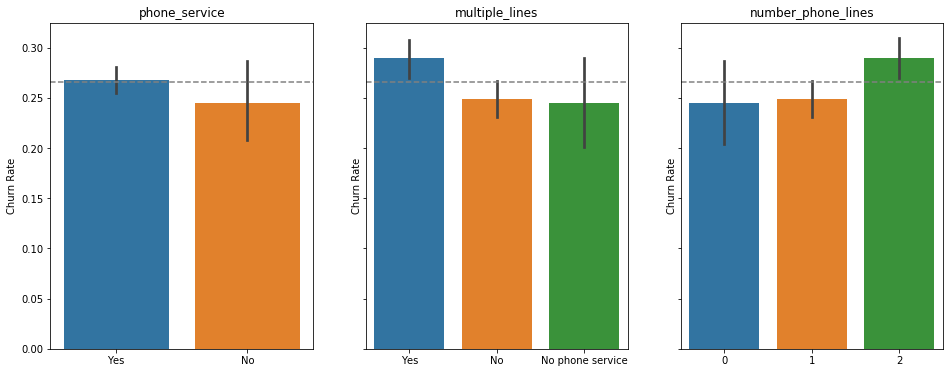

In [24]:
features = ['phone_service', 'multiple_lines', 'number_phone_lines']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Takeaways:
- **Phone Service** - Having or not having phone service does not appear to substantially affect churn.
- **Multiple Lines** - No apparent difference based on having multiple lines.
- **Number Phone Lines** - No apparent difference as number of phone lines increase.

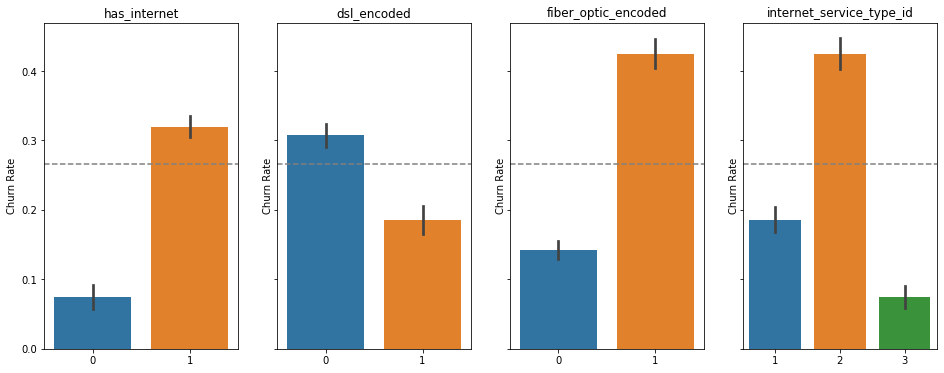

In [25]:
features = ['has_internet', 'dsl_encoded', 'fiber_optic_encoded', 'internet_service_type_id']

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Takeaways
- **Has Internet** - Having internet service appears to be a huge driver of churn.
- **DSL** - Customers with DSL have lower rates of churn than customers who do not have DSL, but this variable combines Fiber Optic and No Internet into a single result (0). As we see further to the right, it is important to distinguish Fiber Optic customers from No internet customers. 
- **Fiber Optic** - Fiber optic customers have substantially higher rates of churn. 
- **internet Service Type** - Although Fiber Optic customers appear to be driving churn, we shouldn't expect customers to move to an older technology (DSL) or abandon internet. Nevertheless, there might be something about the fiber optic experience that is driving customers away. 

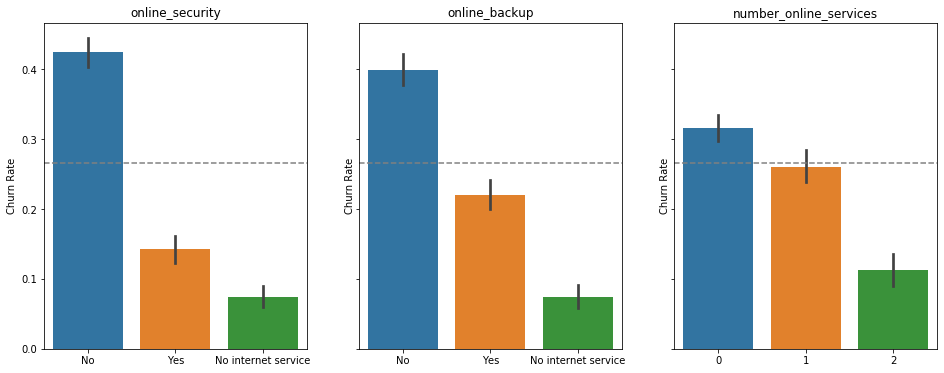

In [26]:
features = ['online_security', 'online_backup', 'number_online_services']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Takeaways
- **Online Security** - Customers with online security appear to churn substantially less than customers without security.
- **Online Backup** - Customers with online backup appear to churn less than those without.
- **Number Online Services** - There appears to be a synergistic effect between Online Security and Online Backup. Customers with both appear to churn less than customers with just one of the two services. 

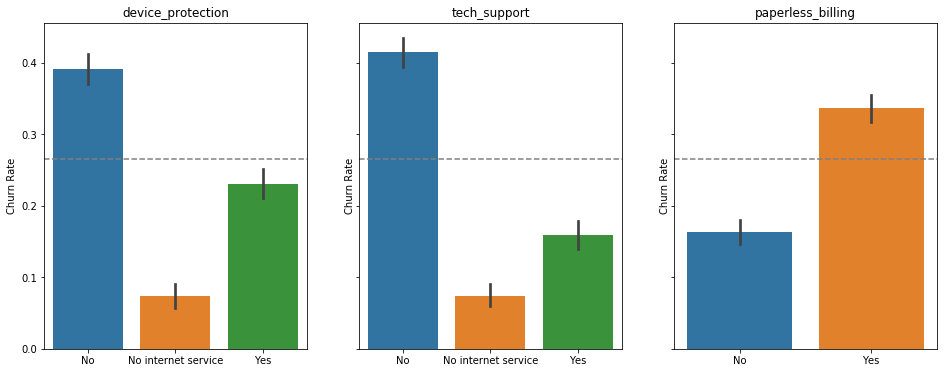

In [27]:
features = ['device_protection', 'tech_support', 'paperless_billing']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Takeaways
- **device protection** - Customers with device protection appear to churn less than customers without protection.
- **tech support** - Customers with tech_support appear to churn less than customers without tech support.
- **paperless billing** - Customers with paperless billing appear to churn at a much higher rate. Given industry trends, we shouldn't expect customers to switch away from paperless billing. There might be something about the paperless billing experience that customers are not appreciating. Should this prove to be a significant difference, we can certainly still include it in our churn prediction model. 

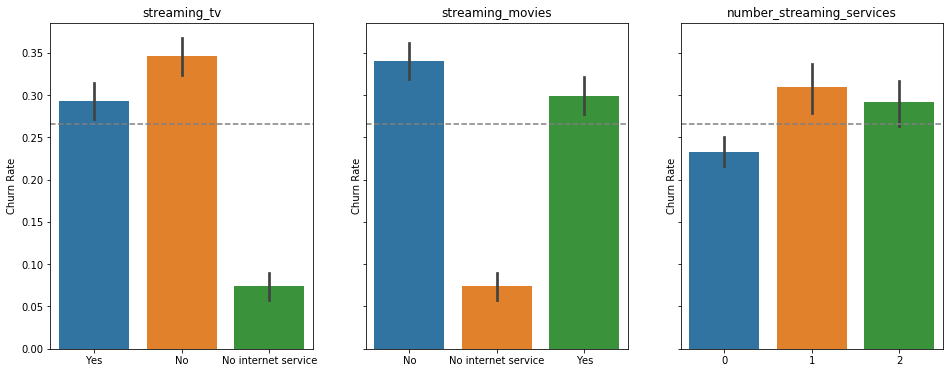

In [28]:
features = ['streaming_tv', 'streaming_movies', 'number_streaming_services']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Takeaways
- **Streaming TV** - There might be a significant difference between customers with streaming_tv and those without, but the difference, if present, appears to be small.
- **Streaming Movies** - There might be a significant difference between customers who can stream movies and those who do not, but the difference appears to be small.
- **Number of Streaming Services** - The pattern is difficult to observe if there is one. Likely no meaningful difference in churn rate between these customer groups. 

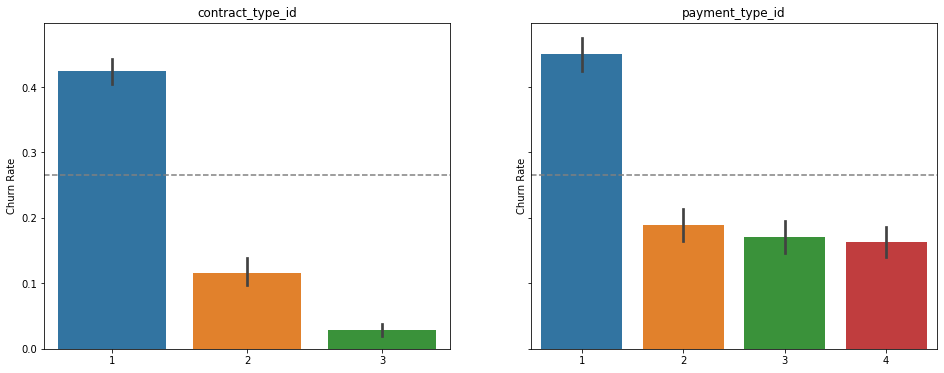

In [29]:
features = ['contract_type_id', 'payment_type_id']

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

In [30]:
train.contract_type_id.value_counts()

1    2491
3    1091
2     918
Name: contract_type_id, dtype: int64

### Takeaways
- **Contract Type** - Customers with month to month contracts are dominating the churn rate and they make up the majority as well. 
- **Payment Type** - Customers who pay by electronic check have substantially higher churn rates. 

Text(0, 0.5, 'Churn Rate')

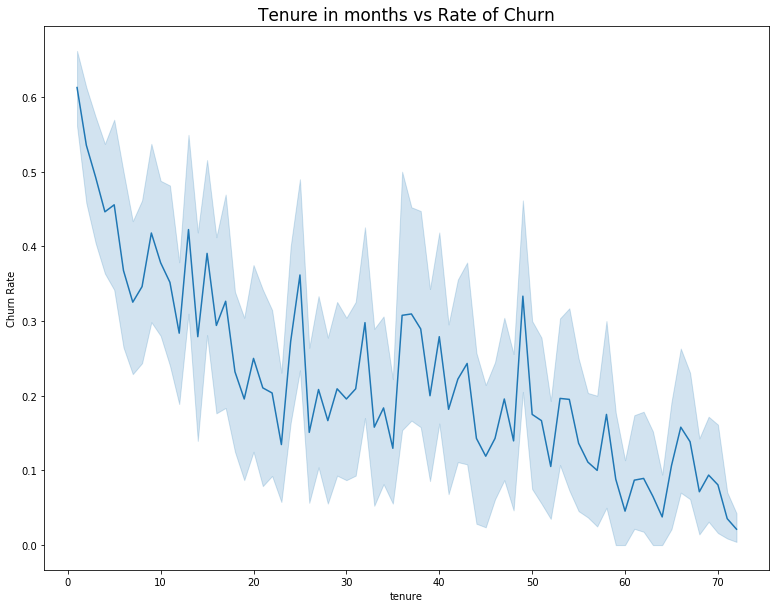

In [31]:
plt.figure('figure', figsize=(13, 10))
plt.title("Tenure in months vs Rate of Churn", fontsize=17)
ax = sns.lineplot(x="tenure", y="churn_encoded", data=train)
plt.ylabel('Churn Rate')

Text(0, 0.5, 'Churn Rate')

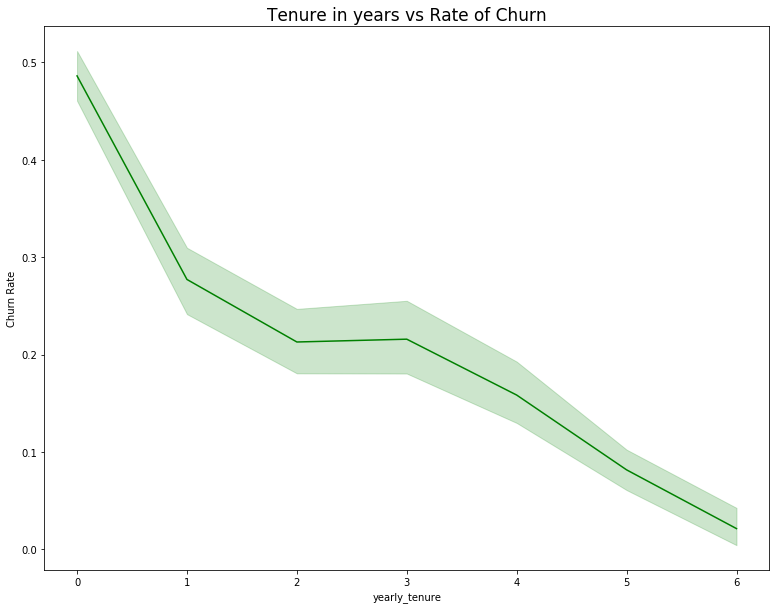

In [32]:
plt.figure('figure', figsize=(13, 10))
plt.title("Tenure in years vs Rate of Churn", fontsize=17)
ax = sns.lineplot(x="yearly_tenure", y="churn_encoded", data=train, color="green")
plt.ylabel('Churn Rate')

### Takeaways - Tenure and Churn
Generally churn rate decreases as tenure increases. We see some spikes at around 24, 36, and 48 months. 

In [33]:
train.groupby('churn').monthly_charges.mean()

churn
No     61.131613
Yes    74.652048
Name: monthly_charges, dtype: float64

In [34]:
train.groupby('churn').total_charges.mean()

churn
No     2553.946519
Yes    1558.279055
Name: total_charges, dtype: float64

### Takeaways - Pricing and Churn
Customers who are churning are paying higher prices.
Customers who are churning provide lower overall revenue than customers who do not, but it is unlikely that these customers are leaving because of their total charges amount. Their total charges are likely lower because they don't have as many months of tenure, which is supported by the visualizations for tenure and churn rate.

## Statistical Analysis of Features

Features of Interest:
- senior_citizen
- number_relationships
- number_online_services
- dsl_encoded
- fiber_encoded
- has_internet
- device_protection_encoded
- tech_support_encoded
- paperless_billing_encoded
- month_to_month_encoded
- electronic_check_encoded
- tenure
- yearly_tenure
- monthly_charges
- total_charges

In [35]:
alpha = 0.01

### Senior Cititzens
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on being a senior citizen.
- (H_a): Rate of churn is dependent on being a senior citizen.

In [36]:
senior_citizen_ctab = pd.crosstab(train.senior_citizen, train.churn)
senior_citizen_ctab

churn,No,Yes
senior_citizen,,
0,2893,884
1,411,312


In [37]:
chi2, p_senior, degf, expected_senior = stats.chi2_contingency(senior_citizen_ctab)
print(expected_senior)
print(f"p-val: {p_senior}")

[[2773.15733333 1003.84266667]
 [ 530.84266667  192.15733333]]
p-val: 5.509370952988315e-28


In [38]:
if p_senior < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Number of Relationships
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on number of relationships.
- (H_a): Rate of churn is dependent on number of relationships.

In [39]:
relationships_ctab = pd.crosstab(train.number_relationships, train.churn)
relationships_ctab

churn,No,Yes
number_relationships,,
0,1369,724
1,974,317
2,961,155


In [40]:
chi2, p_relationships, degf, expected_relationships = stats.chi2_contingency(relationships_ctab)
print(expected_relationships)
print(f"p-val: {p_relationships}")

[[1536.72711111  556.27288889]
 [ 947.88088889  343.11911111]
 [ 819.392       296.608     ]]
p-val: 2.8842063215379543e-36


In [41]:
if p_relationships < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Number of Online Services
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on number of online services.
- (H_a): Rate of churn is dependent on number of online services.

In [42]:
online_services_ctab = pd.crosstab(train.number_online_services, train.churn)
online_services_ctab

churn,No,Yes
number_online_services,,
0,1620,749
1,1038,365
2,646,82


In [43]:
chi2, p_online_services, degf, expected_online_services = stats.chi2_contingency(online_services_ctab)
print(expected_online_services)
print(f"p-val: {p_online_services}")

[[1739.37244444  629.62755556]
 [1030.11377778  372.88622222]
 [ 534.51377778  193.48622222]]
p-val: 1.8143089060271363e-26


In [44]:
if p_online_services < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### DSL
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on DSL status.
- (H_a): Rate of churn is dependent on DSL status.

In [45]:
dsl_ctab = pd.crosstab(train.dsl_encoded, train.churn)
dsl_ctab

churn,No,Yes
dsl_encoded,,
0,2050,910
1,1254,286


In [46]:
chi2, p_dsl, degf, expected_dsl = stats.chi2_contingency(dsl_ctab)
print(expected_dsl)
print(f"p-val: {p_dsl}")

[[2173.29777778  786.70222222]
 [1130.70222222  409.29777778]]
p-val: 2.456346497271359e-18


In [47]:
if p_dsl < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Fiber Optic
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on Fiber Optic status.
- (H_a): Rate of churn is dependent on Fiber Optic status.

In [48]:
fiber_optic_ctab = pd.crosstab(train.fiber_optic_encoded, train.churn)
fiber_optic_ctab

churn,No,Yes
fiber_optic_encoded,,
0,2169,359
1,1135,837


In [49]:
chi2, p_fiber_optic, degf, expected_fiber_optic = stats.chi2_contingency(fiber_optic_ctab)
print(expected_fiber_optic)
print(f"p-val: {p_fiber_optic}")

[[1856.11377778  671.88622222]
 [1447.88622222  524.11377778]]
p-val: 3.5679038758817116e-100


In [50]:
if p_fiber_optic < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Has Internet
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on having an internet product.
- (H_a): Rate of churn is dependent on having an internet product.

In [51]:
has_internet_ctab = pd.crosstab(train.has_internet, train.churn)
has_internet_ctab

churn,No,Yes
has_internet,,
0,915,73
1,2389,1123


In [52]:
chi2, p_has_internet, degf, expected_has_internet = stats.chi2_contingency(has_internet_ctab)
print(expected_has_internet)
print(f"p-val: {p_has_internet}")

[[ 725.41155556  262.58844444]
 [2578.58844444  933.41155556]]
p-val: 1.29849617724919e-53


In [53]:
if p_has_internet < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Device Protection
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on having device protection.
- (H_a): Rate of churn is dependent on having device protection.

In [54]:
device_protection_ctab = pd.crosstab(train.device_protection_encoded, train.churn)
device_protection_ctab

churn,No,Yes
device_protection_encoded,,
0,2102,836
1,1202,360


In [55]:
chi2, p_device_protection, degf, expected_device_protection = stats.chi2_contingency(device_protection_ctab)
print(expected_device_protection)
print(f"p-val: {p_device_protection}")

[[2157.14488889  780.85511111]
 [1146.85511111  415.14488889]]
p-val: 0.00010723338113471185


In [56]:
if p_device_protection < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Tech Support
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on having tech support.
- (H_a): Rate of churn is dependent on having tech support.

In [57]:
tech_support_ctab = pd.crosstab(train.tech_support_encoded, train.churn)
tech_support_ctab

churn,No,Yes
tech_support_encoded,,
0,2208,989
1,1096,207


In [58]:
chi2, p_tech_support, degf, expected_tech_support = stats.chi2_contingency(tech_support_ctab)
print(expected_tech_support)
print(f"p-val: {p_tech_support}")

[[2347.30844444  849.69155556]
 [ 956.69155556  346.30844444]]
p-val: 5.278670925580677e-25


In [59]:
if p_tech_support < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Paperless Billing
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on having paperless billing.
- (H_a): Rate of churn is dependent on having paperless billing.

In [60]:
paperless_ctab = pd.crosstab(train.paperless_billing_encoded, train.churn)
paperless_ctab

churn,No,Yes
paperless_billing_encoded,,
0,1544,302
1,1760,894


In [61]:
chi2, p_paperless, degf, expected_paperless = stats.chi2_contingency(paperless_ctab)
print(expected_paperless)
print(f"p-val: {p_paperless}")

[[1355.37422222  490.62577778]
 [1948.62577778  705.37422222]]
p-val: 4.1261642015393425e-38


In [62]:
if p_paperless < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Month to Month Contracts
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on having a month to month contract.
- (H_a): Rate of churn is dependent on having a month to month contract.

In [63]:
month_to_month_ctab = pd.crosstab(train.month_to_month_encoded, train.churn)
month_to_month_ctab

churn,No,Yes
month_to_month_encoded,,
0,1871,138
1,1433,1058


In [64]:
chi2, p_month_to_month, degf, expected_month_to_month = stats.chi2_contingency(month_to_month_ctab)
print(expected_month_to_month)
print(f"p-val: {p_month_to_month}")

[[1475.05244444  533.94755556]
 [1828.94755556  662.05244444]]
p-val: 9.94407895226434e-159


In [65]:
if p_month_to_month < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Electronic Check
Initial Hypotheses 
- (H_0): Rate of churn is not dependent on using electronic check as the form of payment.
- (H_a): Rate of churn is dependent on using electronic check as the form of payment.

In [66]:
electronic_check_ctab = pd.crosstab(train.electronic_check_encoded, train.churn)
electronic_check_ctab

churn,No,Yes
electronic_check_encoded,,
0,2482,524
1,822,672


In [67]:
chi2, p_electronic_check, degf, expected_electronic_check = stats.chi2_contingency(electronic_check_ctab)
print(expected_electronic_check)
print(f"p-val: {p_electronic_check}")

[[2207.072  798.928]
 [1096.928  397.072]]
p-val: 4.309960183889198e-86


In [68]:
if p_electronic_check < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Tenure
Initial Hypotheses
- (H_0): There is no linear correlation between the monthly tenure and the rate of churn.
- (H_a): There is a linear correlation between the monthly tenure and the rate of churn.

In [69]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .99 # desired confidence interval
alpha = 1 - conf_interval

In [70]:
corr, p_tenure = stats.pearsonr(train.tenure, train.churn_encoded)
corr, p_tenure

(-0.3517299409792577, 3.4605013847339375e-131)

In [71]:
if p_tenure < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Yearly Tenure
Initial Hypotheses
- (H_0): There is no linear correlation between the yearly tenure and the rate of churn.
- (H_a): There is a linear correlation between the yearly tenure and the rate of churn.

In [72]:
corr, p_yearly_tenure = stats.pearsonr(train.yearly_tenure, train.churn_encoded)
corr, p_yearly_tenure

(-0.33807994994440416, 9.895860992184229e-121)

In [73]:
if p_yearly_tenure < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Monthly Charges
Initial Hypotheses
- (H_0): There is no linear correlation between the monthly charges and the rate of churn.
- (H_a): There is a linear correlation between the monthly charges and the rate of churn.

In [74]:
corr, p_monthly_charges = stats.pearsonr(train.monthly_charges, train.churn_encoded)
corr, p_monthly_charges

(0.19772518844763115, 6.684803751537754e-41)

In [75]:
if p_monthly_charges < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Total Charges
Initial Hypotheses
- (H_0): There is no linear correlation between the yearly charges and the rate of churn.
- (H_a): There is a linear correlation between the yearly charges and the rate of churn.

In [76]:
corr, p_total_charges = stats.pearsonr(train.total_charges, train.churn_encoded)
corr, p_total_charges

(-0.19374669433973696, 2.6040601649849352e-39)

In [77]:
if p_total_charges < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Summary of p-values

In [78]:
p_values_all = {'Feature': ['Senior Citizen', 'Number of Relationships', 'Number of Online Services', 'DSL', 'Fiber Optic', 'Has Internet', 'Device Protection', 'Tech Support', 'Paperless Billing', 'Month to Month Contracts', 'Electronic Check Payments', 'Monthly Tenure', 'Yearly Tenure', 'Monthly Charges', 'Total Charges'], 'p-value': [p_senior, p_relationships, p_online_services, p_dsl, p_fiber_optic, p_has_internet, p_device_protection, p_tech_support, p_paperless, p_month_to_month, p_electronic_check, p_tenure, p_yearly_tenure, p_monthly_charges, p_total_charges]}
p_df = pd.DataFrame(data=p_values_all)
p_df.sort_values(by=['p-value'])

,Feature,p-value
9,Month to Month Contracts,9.944079e-159
11,Monthly Tenure,3.460501e-131
12,Yearly Tenure,9.895861e-121
4,Fiber Optic,3.567904e-100
10,Electronic Check Payments,4.309960e-86
5,Has Internet,1.298496e-53
13,Monthly Charges,6.684804e-41
14,Total Charges,2.604060e-39
8,Paperless Billing,4.126164e-38
1,Number of Relationships,2.884206e-36


# Modeling

All of the features investigated rejected the null hypotheses in their respective statistical tests. 
In order to narrow down the features passed into the models to avoid excessive dimensionality, we will use features that had the smallest p-values. 

1. Month-to-month contract status: This has the smallest p-value
2. Monthly tenure: This is similar to yearly tenure both in the size of the coefficient as well as the p-value, so we will use monthly tenure instead of yearly tenure.
3. Fiber optic use: Customers with fiber optic plans appear to be churning at a very high rate, so we will include this feature.
4. Electronic check payment type: Customers who pay by this method are churning at a much higher rate
5. Has Internet: Although fiber optics use covers this partially, there is still enough additional information provided by this feature to include it.
6. Monthly charges: This is similar to total charges, but I suspect that the model will perform better with this feature instead of total charges, as total charges is likely dependent on tenure. 

Because I am trying to predict the customers that will churn, the positive variable will be churn = 1 in my models. 

Possible Outcomes:
- TP: Predict that a customer will churn and they do
- TN: Predict that a customer will not churn and they do not
- FP: Predict that a customer will churn but they do not
- FN: Predict that a customer will not churn but they do

I am trying to identify customers that will churn so I want to minimize false negatives. Accuracy will be the primary measure for selecting a top model, followed by recall. 

In [79]:
def feature_target_selector(features, target, train=train, validate=validate, test=test):
    X_train = train[features]
    y_train = train[target]
    X_validate = validate[features]
    y_validate = validate[target]
    X_test = test[features]
    y_test = test[target]
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [80]:
train.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'gender_encoded', 'partner_encoded',
       'dependents_encoded', 'phone_service_encoded', 'multiple_lines_encoded',
       'online_security_encoded', 'online_backup_encoded',
       'device_protection_encoded', 'tech_support_encoded',
       'streaming_tv_encoded', 'streaming_movies_encoded',
       'paperless_billing_encoded', 'churn_encoded', 'number_phone_lines',
       'number_relationships', 'number_streaming_services',
       'number_online_services', 'yearly_tenure', 'dsl_encoded',
       'fiber_optic_encoded', 'has_internet', 'electronic_check_encoded',
       'mailed_check_encoded', 'ba

In [81]:
features = ['month_to_month_encoded', 'tenure', 'fiber_optic_encoded', 'electronic_check_encoded', 'has_internet', 'monthly_charges']
target = ['churn_encoded']
X_train, y_train, X_validate, y_validate, X_test, y_test = feature_target_selector(features, target)

## Establishing Baseline

Our baseline is a model with no features that predicts no churn (churn = 0) 100% of the time. 

In [82]:
evaluations = pd.DataFrame({"actual": y_validate.churn_encoded})
evaluations["baseline"] = 0
matrix = pd.crosstab(evaluations.actual, evaluations.baseline)
matrix

baseline,0
actual,
0,1033
1,374


In [83]:
baseline_accuracy = (evaluations.baseline == evaluations.actual).mean()

print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 73.42%


## Logistic Regression

In [84]:
logit = LogisticRegression(random_state=123, solver='lbfgs')
logit.fit(X_train, y_train)
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 9.41294126e-01 -3.33002129e-02  1.17767903e+00  4.57129585e-01
   9.28362907e-01  1.14901323e-03]]
Intercept: 
 [-2.44634049]


In [85]:
y_pred1 = logit.predict(X_train)
y_pred1_proba = logit.predict_proba(X_train)

In [86]:
confusion_matrix(y_train, y_pred1)

array([[2981,  323],
       [ 612,  584]])

In [87]:
def print_return_cm_details(y_pred, y_train=y_train):
    true_positive_count = confusion_matrix(y_train, y_pred)[1][1]
    print(f'True positives: {true_positive_count}')
    false_negative_count = confusion_matrix(y_train, y_pred)[1][0]
    print(f'False negatives: {false_negative_count}')
    false_positive_count = confusion_matrix(y_train, y_pred)[0][1]
    print(f'False positives: {false_positive_count}')
    true_negative_count = confusion_matrix(y_train, y_pred)[0][0]
    print(f'True negatives: {true_negative_count}')
    return true_positive_count, false_negative_count, false_positive_count, true_negative_count

print('Positive is defined as churning (churn = 1)')
tp, fn, fp, tn = print_return_cm_details(y_pred1)

Positive is defined as churning (churn = 1)
True positives: 584
False negatives: 612
False positives: 323
True negatives: 2981


In [88]:
print(classification_report(y_train, y_pred1))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3304
           1       0.64      0.49      0.56      1196

    accuracy                           0.79      4500
   macro avg       0.74      0.70      0.71      4500
weighted avg       0.78      0.79      0.78      4500



In [89]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

print('F1 score of Logistic Regression classifier on training set: {:.2f}'
     .format(f1_score(y_train, y_pred1)))

recall_logit = tp/(tp+fn)

print('Recall of Logistic Regression classifier on training set: {:.2f}'
     .format(recall_logit))

Accuracy of Logistic Regression classifier on training set: 0.79
F1 score of Logistic Regression classifier on training set: 0.56
Recall of Logistic Regression classifier on training set: 0.49


## Decision Tree

The optimal max_depth is 31
The accuracy on the train data at this depth is 0.989


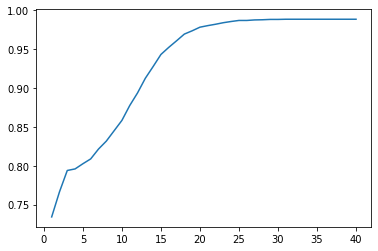

In [90]:
scores = []
for i in range(1, 41):
    tree = DecisionTreeClassifier(random_state = 1, max_depth = i)
    tree.fit(X_train, y_train)
    scores.append(tree.score(X_train, y_train))
max_train_accuracy = max(scores)
max_train_index = scores.index(max_train_accuracy)
optimal_train_depth = max_train_index + 1
print(f'The optimal max_depth is {optimal_train_depth}')
print(f'The accuracy on the train data at this depth is {round(max_train_accuracy, 3)}')

plt.plot(range(1,41), scores)
plt.show()

In [91]:
tree = DecisionTreeClassifier(random_state = 1, max_depth = optimal_train_depth)
tree.fit(X_train, y_train)
y_pred2 = tree.predict(X_train)
y_pred2_proba = tree.predict_proba(X_train)

In [92]:
confusion_matrix(y_train, y_pred2)

array([[3295,    9],
       [  42, 1154]])

In [93]:
print('Positive is defined as churning (churn = 1)')
tp, fn, fp, tn = print_return_cm_details(y_pred2)

Positive is defined as churning (churn = 1)
True positives: 1154
False negatives: 42
False positives: 9
True negatives: 3295


In [94]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3304
           1       0.99      0.96      0.98      1196

    accuracy                           0.99      4500
   macro avg       0.99      0.98      0.99      4500
weighted avg       0.99      0.99      0.99      4500



In [95]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(tree.score(X_train, y_train)))

print('F1 score of Decision Tree classifier on training set: {:.2f}'
     .format(f1_score(y_train, y_pred2)))

recall_tree = tp/(tp+fn)

print('Recall of Decision Tree classifier on training set: {:.2f}'
     .format(recall_tree))

Accuracy of Decision Tree classifier on training set: 0.99
F1 score of Decision Tree classifier on training set: 0.98
Recall of Decision Tree classifier on training set: 0.96


## Random Forest

In [96]:
rf = RandomForestClassifier(random_state = 123, min_samples_leaf = 1, max_depth = 20)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
print(X_train.columns)

[0.09068552 0.300331   0.05852692 0.03511072 0.01475365 0.50059219]
Index(['month_to_month_encoded', 'tenure', 'fiber_optic_encoded',
       'electronic_check_encoded', 'has_internet', 'monthly_charges'],
      dtype='object')


In [97]:
y_pred3 = rf.predict(X_train)
y_pred3_proba = rf.predict_proba(X_train)
print(confusion_matrix(y_train, y_pred3))

[[3279   25]
 [  27 1169]]


In [98]:
print('Positive is defined as churning (churn = 1)')
tp, fn, fp, tn = print_return_cm_details(y_pred3)

Positive is defined as churning (churn = 1)
True positives: 1169
False negatives: 27
False positives: 25
True negatives: 3279


In [99]:
print(classification_report(y_train, y_pred3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3304
           1       0.98      0.98      0.98      1196

    accuracy                           0.99      4500
   macro avg       0.99      0.98      0.99      4500
weighted avg       0.99      0.99      0.99      4500



In [100]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

print('F1 score of Decision Tree classifier on training set: {:.2f}'
     .format(f1_score(y_train, y_pred3)))

recall_rf = tp/(tp+fn)

print('Recall of Decision Tree classifier on training set: {:.2f}'
     .format(recall_rf))

Accuracy of Decision Tree classifier on training set: 0.99
F1 score of Decision Tree classifier on training set: 0.98
Recall of Decision Tree classifier on training set: 0.98


## K-Nearest Neighbors

In [101]:
k = math.floor(math.sqrt(X_train.shape[0]))

In [102]:
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform') #n_neighbors is based on the sqrt of the number of observations
knn.fit(X_train, y_train)
y_pred4 = knn.predict(X_train)
y_pred4_proba = knn.predict_proba(X_train)

In [103]:
print(confusion_matrix(y_train, y_pred4))

[[3041  263]
 [ 659  537]]


In [104]:
print('Positive is defined as churning (churn = 1)')
tp, fn, fp, tn = print_return_cm_details(y_pred4)

Positive is defined as churning (churn = 1)
True positives: 537
False negatives: 659
False positives: 263
True negatives: 3041


In [105]:
print(classification_report(y_train, y_pred4))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3304
           1       0.67      0.45      0.54      1196

    accuracy                           0.80      4500
   macro avg       0.75      0.68      0.70      4500
weighted avg       0.78      0.80      0.78      4500



In [106]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

print('F1 score of Decision Tree classifier on training set: {:.2f}'
     .format(f1_score(y_train, y_pred4)))

recall_knn = tp/(tp+fn)

print('Recall of Decision Tree classifier on training set: {:.2f}'
     .format(recall_knn))

Accuracy of Decision Tree classifier on training set: 0.80
F1 score of Decision Tree classifier on training set: 0.54
Recall of Decision Tree classifier on training set: 0.45


## Model Performance on Validate

In [107]:
print("Model 1: Logistic Regression")

print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

y_pred1 = logit.predict(X_validate)

print(confusion_matrix(y_validate, y_pred1))

print(classification_report(y_validate, y_pred1))

Model 1: Logistic Regression
Accuracy: 0.80
[[922 111]
 [175 199]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [108]:
print("Model 2: Decision Tree")

print('Accuracy: {:.2f}'.format(tree.score(X_validate, y_validate)))

y_pred2 = tree.predict(X_validate)

print(confusion_matrix(y_validate, y_pred2))

print(classification_report(y_validate, y_pred2))

Model 2: Decision Tree
Accuracy: 0.74
[[859 174]
 [193 181]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1033
           1       0.51      0.48      0.50       374

    accuracy                           0.74      1407
   macro avg       0.66      0.66      0.66      1407
weighted avg       0.74      0.74      0.74      1407



In [109]:
print("Model 3: Random Forest")

print('Accuracy: {:.2f}'.format(rf.score(X_validate, y_validate)))

y_pred3 = rf.predict(X_validate)

print(confusion_matrix(y_validate, y_pred3))

print(classification_report(y_validate, y_pred3))

Model 3: Random Forest
Accuracy: 0.76
[[891 142]
 [193 181]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1033
           1       0.56      0.48      0.52       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.76      1407



In [110]:
print("Model 4: K-Nearest Neighbors")

print('Accuracy: {:.2f}'.format(knn.score(X_validate, y_validate)))

y_pred4 = knn.predict(X_validate)

print(confusion_matrix(y_validate, y_pred4))

print(classification_report(y_validate, y_pred4))

Model 4: K-Nearest Neighbors
Accuracy: 0.80
[[948  85]
 [200 174]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1033
           1       0.67      0.47      0.55       374

    accuracy                           0.80      1407
   macro avg       0.75      0.69      0.71      1407
weighted avg       0.78      0.80      0.78      1407



### Logistic Regression Model has the highest combination of accuracy and recall

## Model Performance on Test

In [111]:
print("Test Performance: Logistic Regression")

print('Accuracy: {:.4f}'.format(logit.score(X_test, y_test)))

y_pred5 = logit.predict(X_test)

print(confusion_matrix(y_test, y_pred5))

print(classification_report(y_test, y_pred5))

Test Performance: Logistic Regression
Accuracy: 0.7751
[[731  95]
 [158 141]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       826
           1       0.60      0.47      0.53       299

    accuracy                           0.78      1125
   macro avg       0.71      0.68      0.69      1125
weighted avg       0.76      0.78      0.77      1125



#### Baseline has an accuracy of 73.42%

#### The developed logistic regression model has an accuracy of 77.51%

## Prediction CSV File

In [112]:
full_df = prep_telco_data_prediction(telco_original)

In [113]:
full_df_trim = full_df[features]

In [114]:
full_df['prediction'] = logit.predict(full_df_trim)

In [115]:
full_df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,fiber_optic_encoded,has_internet,electronic_check_encoded,mailed_check_encoded,bank_transfer_encoded,credit_card_encoded,month_to_month_encoded,one_year_contract_encoded,two_year_contract_encoded,prediction
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,0,1,0,1,0,0,0,1,0,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,0,1,0,1,0,0,1,0,0,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,1,1,1,0,0,0,1,0,0,1
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,...,1,1,1,0,0,0,1,0,0,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,...,1,1,0,1,0,0,1,0,0,1


In [116]:
predictions = full_df[['customer_id', 'prediction']]
predictions.head()

,customer_id,prediction
0,0002-ORFBO,0
1,0003-MKNFE,0
2,0004-TLHLJ,1
3,0011-IGKFF,1
4,0013-EXCHZ,1


In [117]:
predictions.to_csv('predictions.csv')

# Conclusion

A number of factors are contributing to churn. We can attempt to reduce churn by doing the following:
1. Marketing to younger families with dependents and partners.
2. Promoting online security and online backup to our internet customers.
3. Promoting tech support and device protection. 
4. Discouraging the use of electronic checks for payment purposes.

With additional time dedicated to this project:
1. Investigate fiber optic customers in greater detail and look at possible combinations of factors that might be driving churn within that group.
2. Investigate our pricing structure across various services to identify if our pricing strategy may be suboptimal.
3. Improve the readibility of the report via additional comments, markdown cells, and summary tables.
4. Include a meaningful readme for github containing project description with goals, a data dictionary, project planning, an explanation of how someone else can recreate this project and findings, and key takeaways from this project.
5. Include a data dictionary.
6. Increase the number of models to test, especially focusing on hyperparameters and feature engineering to improve model performance. 

Included in the github repository is a CSV that contains a prediction for every customer, except for customers with 0 tenure. Those customers have 0% chance to be predicted to have churned.